# Visual Search - Computer Vision II 22/23

Author: Pedro Guijas Bravo


## Initial Setup

### Imports

In [16]:
!pip install pytorch-metric-learning
!pip install -q faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pytorch_metric_learning.utils import common_functions as c_f
from torch import optim

from pytorch_metric_learning.distances import LpDistance
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils.inference import CustomKNN
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [18]:
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
    
device = torch.device(device_name)
print(f"Code runs in {device}")


Code runs in cuda


In [31]:
from google.colab import drive
drive.mount('/content/drive')

### Load Data

In [20]:
# Display samples
def show_samples(dataset):
    labels_to_indices = c_f.get_labels_to_indices(dataset.targets)
    indexes = [labels_to_indices[i] for i in np.arange(0,24)]

    cols, rows = 8, 3
    figure = plt.figure(figsize=(cols*2, rows*2))

    for i in range(0, cols * rows):
        sample, label = dataset[indexes[i][0]]
        figure.add_subplot(rows, cols, i+1)
        plt.title(f'Class {dataset.classes[label]}')
        plt.axis("off")
        plt.imshow(sample.permute(1, 2, 0), cmap="gray")
    plt.show()

Train: Dataset ImageFolder
    Number of datapoints: 1071
    Root location: /content/drive/MyDrive/datasets/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
 Validation: Dataset ImageFolder
    Number of datapoints: 135
    Root location: /content/drive/MyDrive/datasets/dataset/valid
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
 Test: Dataset ImageFolder
    Number of datapoints: 56
    Root location: /content/drive/MyDrive/datasets/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
         

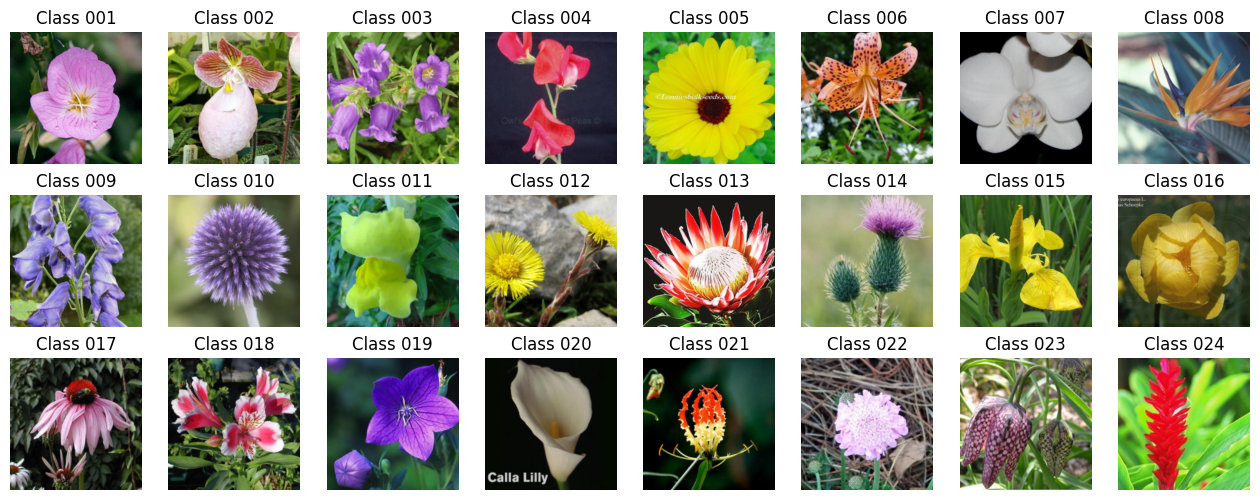

In [21]:
DS_PATH = '/content/drive/MyDrive/datasets/dataset'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor()
])

dataset_train = datasets.ImageFolder(root=f'{DS_PATH}/train', transform=transform)
dataset_valid = datasets.ImageFolder(root=f'{DS_PATH}/valid', transform=transform)
dataset_test = datasets.ImageFolder(root=f'{DS_PATH}/test', transform=transform)

print(f'Train: {dataset_train}\n', f'Validation: {dataset_valid}\n', f'Test: {dataset_test}\n')

# Display labels and samples
print(f"Labels (f{len(dataset_train.classes)}): {dataset_train.classes}")
show_samples(dataset_train)

## Task1: Visual search from pretrained CNN

### Compute embeddings for query image and reference set

In [22]:
# ImageNet ResNet pretrained model
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

# Remove the last layers (fc)
model = nn.Sequential(*list(model.children())[:-1]) 
model = model.to(device)

# obtain the model embedding
def get_embedding(model, image):
    model.eval()
    with torch.no_grad():
        embedding = model(image)
    embedding = embedding.reshape(1, -1)
    return embedding

### Compute similarity metric and Rank the k most similar images

#### Custom similarity functions (not used)

In [ ]:
def compute_similarity(model, img1, img2, f):
    embedding1 = get_embedding(model, img1.unsqueeze(0).to(device))
    embedding2 = get_embedding(model, img2.unsqueeze(0).to(device))
    # cosine similarity
    return f(embedding1, embedding2).item()

def similarity_unused(model, source_img_og, ref_dataset, specific_images=None, f=nn.CosineSimilarity(dim=1, eps=1e-6), k=None, debug=True):
    # Get images
    specific_images = range(len(ref_dataset)) if specific_images is None else specific_images
    ref_imgs = [ref_dataset[i][0] for i in specific_images]
    ref_labels = [ref_dataset[i][1] for i in specific_images]

    # Search most similar image
    similarities = []
    for i,img in enumerate(ref_imgs):
        similarities.append(compute_similarity(model, source_img_og, img, f=f))

    # Rank images
    ranking = np.argsort(similarities)[::-1]
    if k is not None:
        ranking = ranking[:k]

    if debug:
        # Plot source image
        plt.figure(figsize=(4, 4))
        plt.imshow(source_img_og.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

        # Plot ranking images with labels
        plt.figure(figsize=(16, 4))
        for i,r in enumerate(ranking):
            img = ref_imgs[r]
            label = ref_labels[r]
            plt.subplot(1, len(ranking), i+1)
            plt.imshow(img.permute(1, 2, 0))
            plt.axis('off')
            plt.title(label)

        # Print also a ranking of the images
        print(f"Ranking of the images: {ranking}")

        # Print similarities
        print(f"Similarities: {np.array(similarities)[ranking[:k]]}")

    # Return ranking
    return ranking

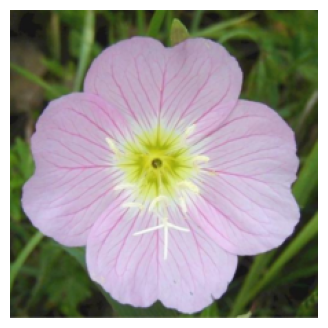

Ranking of the images: [  2  12   6  14   0  25  11   7   5 186   1  17  22   9  16   4 172 795
 151 157]
Similarities: [0.95055026 0.93011963 0.91702163 0.91208577 0.90968525 0.90176487
 0.89786965 0.89711916 0.89391625 0.88831961 0.88714904 0.88586199
 0.88415217 0.88345146 0.8833288  0.87929773 0.87902355 0.87450933
 0.87290049 0.87130374]


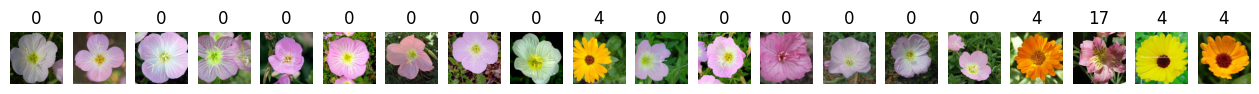

In [ ]:
_ = similarity_unused(model, dataset_test[0][0], dataset_train, k=20)


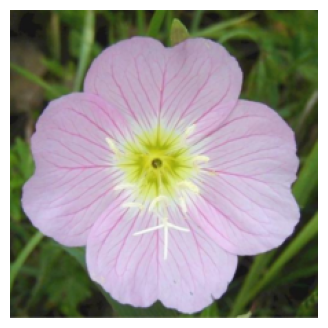

Ranking of the images: [  2  12   6  14 186   1  11  17   4   9   0   5  25   7 189 729 170 159
 842  16]
Similarities: [ -7.56437016  -9.67974663  -9.89228916 -10.40539455 -11.04713535
 -11.10581589 -11.23545837 -11.23731613 -11.50197506 -11.63010502
 -11.77796459 -12.0593338  -12.10902596 -12.13341522 -12.16358089
 -12.18124104 -12.22324657 -12.22428513 -12.25883102 -12.26211166]


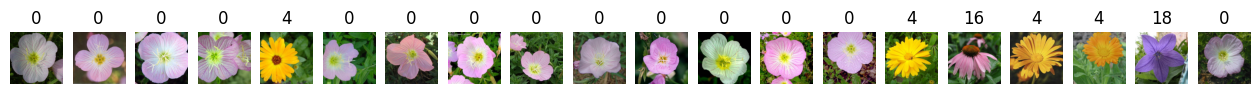

In [ ]:
# same with other similarity (does not work so well)
f = lambda x,y: -nn.functional.pairwise_distance(x, y)
_ = similarity_unused(model, dataset_test[0][0], dataset_train, f=f, k=20)

#### PyTorch Metric Learning similarity functions
 

In [29]:
# Create a custom knn
knn_cos = CustomKNN(CosineSimilarity())
knn_euclidean = CustomKNN(LpDistance())

def similarity(model, source_img_og, ref_dataset, k, specific_images=None, knn_func=knn_cos, debug=True):
    # Get images
    specific_images = len(ref_dataset) if specific_images is None else specific_images
    ref_imgs_og = [ref_dataset[i][0] for i in specific_images]
    ref_labels = [ref_dataset[i][1] for i in specific_images]

    # Compute embeddings
    source_img = get_embedding(model, source_img_og.unsqueeze(0).to(device))
    ref_imgs = [get_embedding(model, img.unsqueeze(0).to(device)) for img in ref_imgs_og]
    ref_imgs = torch.stack(ref_imgs).reshape(len(specific_images), -1)

    # Get nearest neighbors
    similarity, ranking = knn_func(source_img, k, ref_imgs, False) # revisar este false y la k

    # Squeeze (only 1 query)
    similarity = similarity.squeeze()
    ranking = ranking.squeeze()

    if debug:
        # Plot source image
        plt.figure(figsize=(4, 4))
        plt.imshow(source_img_og.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

        # Plot ranking images with labels
        plt.figure(figsize=(16, 4))
        for i,r in enumerate(ranking):
            img = ref_imgs_og[r]
            label = ref_labels[r]
            plt.subplot(1, len(ranking), i+1)
            plt.imshow(img.permute(1, 2, 0))
            plt.axis('off')
            plt.title(label)

        # Print also a ranking of the images
        print(f"Ranking of the images: {ranking}")
        print(f"Similarity: {similarity}")

    # Return ranking
    return ranking

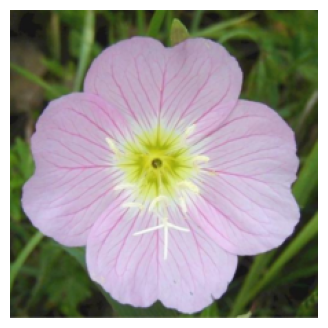

Ranking of the images: tensor([  2,  12,   6,  14,   0,  25,  11,   7,   5, 186,   1,  17,  22,   9,
         16,   4, 172, 795, 151, 157], device='cuda:0')
Similarity: tensor([0.9506, 0.9301, 0.9170, 0.9121, 0.9097, 0.9018, 0.8979, 0.8971, 0.8939,
        0.8883, 0.8871, 0.8859, 0.8842, 0.8835, 0.8833, 0.8793, 0.8790, 0.8745,
        0.8729, 0.8713], device='cuda:0')


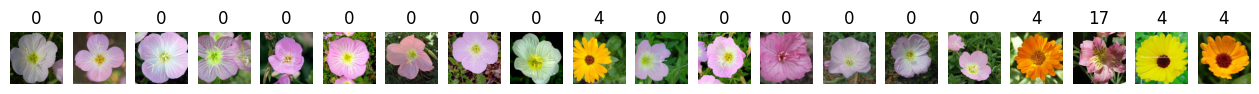

In [ ]:
_ = similarity(model, dataset_test[0][0], dataset_train, k=20, specific_images=range(0, len(dataset_train)), knn_func=knn_cos)

### Compute performance metrics

In [28]:
def similarity_performance(model, dataset_train, dataset_test, k=None, query_limit=None, debug=True):
    # Set params
    k = len(dataset_train) if k is None else k
    amount_queries = len(dataset_test) if query_limit is None else query_limit

    # Queries from the train dataset
    query = [get_embedding(model, dataset_test[i][0].unsqueeze(0).to(device)) for i in range(0, amount_queries)]
    query_labels = [dataset_test[i][1] for i in range(0, amount_queries)]
    query = torch.stack(query).reshape(amount_queries, -1)
    query_labels = torch.tensor(query_labels)

    # References from the test dataset
    reference = [get_embedding(model, dataset_train[i][0].unsqueeze(0).to(device)) for i in range(0, len(dataset_train))]
    reference_labels = [dataset_train[i][1] for i in range(0, len(dataset_train))]
    reference = torch.stack(reference).squeeze()
    reference_labels = torch.tensor(reference_labels)

    # Print shapes
    if debug:
        print(f"Query shape: {query.shape}")
        print(f"Query labels shape: {query_labels.shape}")
        print(f"Reference shape: {reference.shape}")
        print(f"Reference labels shape: {reference_labels.shape}")

    ac = AccuracyCalculator(knn_func=knn_cos, k=k, device=device)
    return ac.get_accuracy(query, query_labels, reference=reference, reference_labels=reference_labels)

In [ ]:
similarity_performance(model, dataset_train, dataset_test)

Query shape: torch.Size([56, 512])
Query labels shape: torch.Size([56])
Reference shape: torch.Size([1071, 512])
Reference labels shape: torch.Size([1071])


{'AMI': 0.42553666868071754,
 'NMI': 0.8235674281320028,
 'mean_average_precision': 0.6559788318699954,
 'mean_average_precision_at_r': 0.528799204145655,
 'mean_reciprocal_rank': 0.9910714626312256,
 'precision_at_1': 0.9821428571428571,
 'r_precision': 0.5939510577604414}


## Task2: Learning an embedding

Note: image normalization not needed image pixels in the [0,1] range.

### Train function (fine-tuning)

In [24]:
import time 
import copy
from pytorch_metric_learning import losses, miners, distances, reducers
from tqdm import tqdm

def train_model(model, dataloaders, optimizer, num_epochs=25, contrastive_loss=False):

    # use the cosine similarity
    distance = distances.CosineSimilarity()
    # ensure that negative losses dont affect the loss
    reducer = reducers.ThresholdReducer(low=0) 

    # Contrastive os Triplet loss
    if contrastive_loss:
      mining_func = None
      loss_func = losses.ContrastiveLoss(pos_margin = 1, neg_margin = 0, distance=distance, reducer=reducer)
    else:
      mining_func = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")
      loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)

    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    # Predict
                    embeddings = model(inputs).squeeze()

                    # Loss
                    if mining_func is None:
                      loss = loss_func(embeddings, labels)
                    else:
                      # Mining
                      indices_tuple = mining_func(embeddings, labels)
                      loss = loss_func(embeddings, labels, indices_tuple)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss > best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)

        print()

    # Show metrics
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # Plot progress
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(train_loss_history, label="loss")
    plt.plot(val_loss_history, label="validation")
    plt.legend()
    plt.show()


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Set dataloaders

In [ ]:
# Data augmentation and normalization for training -> mirar de meter DA

# Create Dataloaders dict
batch_size = 64
dataloaders_dict = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=2)
}

### Contrastive loss

Epoch 0/149
----------


train Loss: 0.8766


val Loss: 0.8567

Epoch 1/149
----------


train Loss: 0.8673


val Loss: 0.8453

Epoch 2/149
----------


train Loss: 0.8597


val Loss: 0.8520

Epoch 3/149
----------


train Loss: 0.8443


val Loss: 0.8322

Epoch 4/149
----------


train Loss: 0.8335


val Loss: 0.8191

Epoch 5/149
----------


train Loss: 0.8253


val Loss: 0.8199

Epoch 6/149
----------


train Loss: 0.8112


val Loss: 0.8089

Epoch 7/149
----------


train Loss: 0.7976


val Loss: 0.7965

Epoch 8/149
----------


train Loss: 0.7919


val Loss: 0.7611

Epoch 9/149
----------


train Loss: 0.7755


val Loss: 0.7631

Epoch 10/149
----------


train Loss: 0.7654


val Loss: 0.7554

Epoch 11/149
----------


train Loss: 0.7531


val Loss: 0.7481

Epoch 12/149
----------


train Loss: 0.7409


val Loss: 0.7234

Epoch 13/149
----------


train Loss: 0.7269


val Loss: 0.7287

Epoch 14/149
----------


train Loss: 0.7148


val Loss: 0.7110

Epoch 15/149
----------


train Loss: 0.7090


val Loss: 0.7075

Epoch 16/149
----------


train Loss: 0.6988


val Loss: 0.6970

Epoch 17/149
----------


train Loss: 0.6822


val Loss: 0.6789

Epoch 18/149
----------


train Loss: 0.6685


val Loss: 0.6714

Epoch 19/149
----------


train Loss: 0.6588


val Loss: 0.6535

Epoch 20/149
----------


train Loss: 0.6491


val Loss: 0.6543

Epoch 21/149
----------


train Loss: 0.6375


val Loss: 0.6375

Epoch 22/149
----------


train Loss: 0.6343


val Loss: 0.6282

Epoch 23/149
----------


train Loss: 0.6204


val Loss: 0.6202

Epoch 24/149
----------


train Loss: 0.6148


val Loss: 0.6298

Epoch 25/149
----------


train Loss: 0.6048


val Loss: 0.6136

Epoch 26/149
----------


train Loss: 0.5912


val Loss: 0.6023

Epoch 27/149
----------


train Loss: 0.5879


val Loss: 0.5968

Epoch 28/149
----------


train Loss: 0.5796


val Loss: 0.5872

Epoch 29/149
----------


train Loss: 0.5711


val Loss: 0.5803

Epoch 30/149
----------


train Loss: 0.5652


val Loss: 0.5555

Epoch 31/149
----------


train Loss: 0.5522


val Loss: 0.5517

Epoch 32/149
----------


train Loss: 0.5485


val Loss: 0.5650

Epoch 33/149
----------


train Loss: 0.5427


val Loss: 0.5605

Epoch 34/149
----------


train Loss: 0.5356


val Loss: 0.5507

Epoch 35/149
----------


train Loss: 0.5263


val Loss: 0.5489

Epoch 36/149
----------


train Loss: 0.5234


val Loss: 0.5389

Epoch 37/149
----------


train Loss: 0.5167


val Loss: 0.5306

Epoch 38/149
----------


train Loss: 0.5132


val Loss: 0.5218

Epoch 39/149
----------


train Loss: 0.5007


val Loss: 0.5121

Epoch 40/149
----------


train Loss: 0.4996


val Loss: 0.5060

Epoch 41/149
----------


train Loss: 0.4909


val Loss: 0.5081

Epoch 42/149
----------


train Loss: 0.4878


val Loss: 0.4973

Epoch 43/149
----------


train Loss: 0.4776


val Loss: 0.4973

Epoch 44/149
----------


train Loss: 0.4727


val Loss: 0.4874

Epoch 45/149
----------


train Loss: 0.4719


val Loss: 0.4954

Epoch 46/149
----------


train Loss: 0.4656


val Loss: 0.4757

Epoch 47/149
----------


train Loss: 0.4596


val Loss: 0.4684

Epoch 48/149
----------


train Loss: 0.4545


val Loss: 0.4684

Epoch 49/149
----------


train Loss: 0.4539


val Loss: 0.4607

Epoch 50/149
----------


train Loss: 0.4511


val Loss: 0.4620

Epoch 51/149
----------


train Loss: 0.4404


val Loss: 0.4517

Epoch 52/149
----------


train Loss: 0.4394


val Loss: 0.4563

Epoch 53/149
----------


train Loss: 0.4356


val Loss: 0.4555

Epoch 54/149
----------


train Loss: 0.4280


val Loss: 0.4547

Epoch 55/149
----------


train Loss: 0.4258


val Loss: 0.4317

Epoch 56/149
----------


train Loss: 0.4232


val Loss: 0.4310

Epoch 57/149
----------


train Loss: 0.4163


val Loss: 0.4266

Epoch 58/149
----------


train Loss: 0.4157


val Loss: 0.4201

Epoch 59/149
----------


train Loss: 0.4128


val Loss: 0.4267

Epoch 60/149
----------


train Loss: 0.4037


val Loss: 0.4209

Epoch 61/149
----------


train Loss: 0.4057


val Loss: 0.4255

Epoch 62/149
----------


train Loss: 0.3988


val Loss: 0.4153

Epoch 63/149
----------


train Loss: 0.3956


val Loss: 0.4098

Epoch 64/149
----------


train Loss: 0.3920


val Loss: 0.4100

Epoch 65/149
----------


train Loss: 0.3896


val Loss: 0.4063

Epoch 66/149
----------


train Loss: 0.3847


val Loss: 0.4014

Epoch 67/149
----------


train Loss: 0.3827


val Loss: 0.4053

Epoch 68/149
----------


train Loss: 0.3814


val Loss: 0.4043

Epoch 69/149
----------


train Loss: 0.3774


val Loss: 0.3861

Epoch 70/149
----------


train Loss: 0.3742


val Loss: 0.3868

Epoch 71/149
----------


train Loss: 0.3704


val Loss: 0.3843

Epoch 72/149
----------


train Loss: 0.3722


val Loss: 0.3811

Epoch 73/149
----------


train Loss: 0.3670


val Loss: 0.3849

Epoch 74/149
----------


train Loss: 0.3658


val Loss: 0.3796

Epoch 75/149
----------


train Loss: 0.3563


val Loss: 0.3760

Epoch 76/149
----------


train Loss: 0.3573


val Loss: 0.3692

Epoch 77/149
----------


train Loss: 0.3526


val Loss: 0.3817

Epoch 78/149
----------


train Loss: 0.3474


val Loss: 0.3782

Epoch 79/149
----------


train Loss: 0.3481


val Loss: 0.3663

Epoch 80/149
----------


train Loss: 0.3428


val Loss: 0.3573

Epoch 81/149
----------


train Loss: 0.3405


val Loss: 0.3504

Epoch 82/149
----------


train Loss: 0.3409


val Loss: 0.3565

Epoch 83/149
----------


train Loss: 0.3383


val Loss: 0.3539

Epoch 84/149
----------


train Loss: 0.3340


val Loss: 0.3503

Epoch 85/149
----------


train Loss: 0.3333


val Loss: 0.3606

Epoch 86/149
----------


train Loss: 0.3359


val Loss: 0.3427

Epoch 87/149
----------


train Loss: 0.3288


val Loss: 0.3470

Epoch 88/149
----------


train Loss: 0.3271


val Loss: 0.3453

Epoch 89/149
----------


train Loss: 0.3228


val Loss: 0.3390

Epoch 90/149
----------


train Loss: 0.3184


val Loss: 0.3486

Epoch 91/149
----------


train Loss: 0.3203


val Loss: 0.3377

Epoch 92/149
----------


train Loss: 0.3163


val Loss: 0.3326

Epoch 93/149
----------


train Loss: 0.3108


val Loss: 0.3360

Epoch 94/149
----------


train Loss: 0.3131


val Loss: 0.3300

Epoch 95/149
----------


train Loss: 0.3133


val Loss: 0.3234

Epoch 96/149
----------


train Loss: 0.3101


val Loss: 0.3169

Epoch 97/149
----------


train Loss: 0.3055


val Loss: 0.3208

Epoch 98/149
----------


train Loss: 0.3067


val Loss: 0.3236

Epoch 99/149
----------


train Loss: 0.2989


val Loss: 0.3220

Epoch 100/149
----------


train Loss: 0.2970


val Loss: 0.3130

Epoch 101/149
----------


train Loss: 0.2973


val Loss: 0.3121

Epoch 102/149
----------


train Loss: 0.2962


val Loss: 0.3132

Epoch 103/149
----------


train Loss: 0.2917


val Loss: 0.3092

Epoch 104/149
----------


train Loss: 0.2927


val Loss: 0.3135

Epoch 105/149
----------


train Loss: 0.2906


val Loss: 0.3082

Epoch 106/149
----------


train Loss: 0.2899


val Loss: 0.3046

Epoch 107/149
----------


train Loss: 0.2881


val Loss: 0.3061

Epoch 108/149
----------


train Loss: 0.2850


val Loss: 0.3001

Epoch 109/149
----------


train Loss: 0.2825


val Loss: 0.2953

Epoch 110/149
----------


train Loss: 0.2820


val Loss: 0.3012

Epoch 111/149
----------


train Loss: 0.2824


val Loss: 0.2998

Epoch 112/149
----------


train Loss: 0.2797


val Loss: 0.2959

Epoch 113/149
----------


train Loss: 0.2753


val Loss: 0.2885

Epoch 114/149
----------


train Loss: 0.2730


val Loss: 0.2918

Epoch 115/149
----------


train Loss: 0.2743


val Loss: 0.2868

Epoch 116/149
----------


train Loss: 0.2757


val Loss: 0.2797

Epoch 117/149
----------


train Loss: 0.2713


val Loss: 0.2884

Epoch 118/149
----------


train Loss: 0.2677


val Loss: 0.2837

Epoch 119/149
----------


train Loss: 0.2673


val Loss: 0.2763

Epoch 120/149
----------


train Loss: 0.2676


val Loss: 0.2768

Epoch 121/149
----------


train Loss: 0.2675


val Loss: 0.2804

Epoch 122/149
----------


train Loss: 0.2632


val Loss: 0.2817

Epoch 123/149
----------


train Loss: 0.2608


val Loss: 0.2749

Epoch 124/149
----------


train Loss: 0.2602


val Loss: 0.2783

Epoch 125/149
----------


train Loss: 0.2596


val Loss: 0.2705

Epoch 126/149
----------


train Loss: 0.2545


val Loss: 0.2654

Epoch 127/149
----------


train Loss: 0.2555


val Loss: 0.2703

Epoch 128/149
----------


train Loss: 0.2545


val Loss: 0.2661

Epoch 129/149
----------


train Loss: 0.2539


val Loss: 0.2667

Epoch 130/149
----------


train Loss: 0.2537


val Loss: 0.2702

Epoch 131/149
----------


train Loss: 0.2569


val Loss: 0.2620

Epoch 132/149
----------


train Loss: 0.2521


val Loss: 0.2634

Epoch 133/149
----------


train Loss: 0.2441


val Loss: 0.2666

Epoch 134/149
----------


train Loss: 0.2480


val Loss: 0.2644

Epoch 135/149
----------


train Loss: 0.2421


val Loss: 0.2638

Epoch 136/149
----------


train Loss: 0.2426


val Loss: 0.2537

Epoch 137/149
----------


train Loss: 0.2408


val Loss: 0.2560

Epoch 138/149
----------


train Loss: 0.2414


val Loss: 0.2587

Epoch 139/149
----------


train Loss: 0.2377


val Loss: 0.2626

Epoch 140/149
----------


train Loss: 0.2412


val Loss: 0.2779

Epoch 141/149
----------


train Loss: 0.2372


val Loss: 0.2494

Epoch 142/149
----------


train Loss: 0.2313


val Loss: 0.2586

Epoch 143/149
----------


train Loss: 0.2334


val Loss: 0.2469

Epoch 144/149
----------


train Loss: 0.2345


val Loss: 0.2438

Epoch 145/149
----------


train Loss: 0.2317


val Loss: 0.2491

Epoch 146/149
----------


train Loss: 0.2303


val Loss: 0.2467

Epoch 147/149
----------


train Loss: 0.2304


val Loss: 0.2524

Epoch 148/149
----------


train Loss: 0.2249


val Loss: 0.2444

Epoch 149/149
----------


train Loss: 0.2273


val Loss: 0.2358

Training complete in 31m 20s
Best val loss: 0.856696


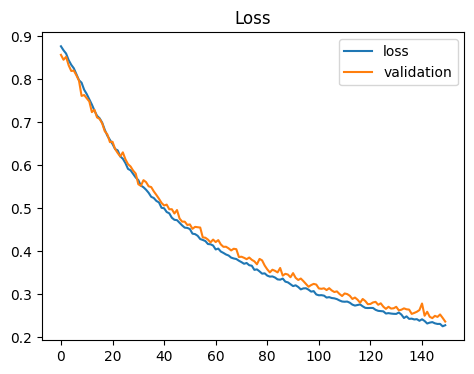

In [ ]:
model_cl = copy.deepcopy(model)
model_cl = model_cl.to(device)
optimizer_ft = optim.SGD(model_cl.parameters(), lr=0.001, momentum=0.9)
model_cl = train_model(model_cl, dataloaders_dict, optimizer_ft, num_epochs=150, contrastive_loss=True)


In [ ]:
similarity_performance(model_cl, dataset_train, dataset_test)


Query shape: torch.Size([56, 512])
Query labels shape: torch.Size([56])
Reference shape: torch.Size([1071, 512])
Reference labels shape: torch.Size([1071])


{'AMI': 0.35180670244209566,
 'NMI': 0.8066679932864622,
 'mean_average_precision': 0.7304570974186386,
 'mean_average_precision_at_r': 0.6099170917849399,
 'mean_reciprocal_rank': 0.9843750596046448,
 'precision_at_1': 0.9821428571428571,
 'r_precision': 0.6676344274114404}

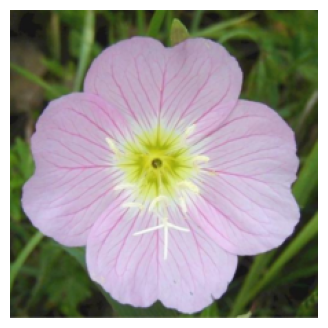

Ranking of the images: tensor([ 2, 25,  7, 12,  9, 16,  6, 11, 23,  0, 17, 14,  4, 20, 10, 13,  5,  1,
        22, 18], device='cuda:0')
Similarity: tensor([0.8906, 0.8885, 0.8745, 0.8631, 0.8447, 0.8365, 0.8305, 0.8292, 0.8280,
        0.8210, 0.8141, 0.8100, 0.8089, 0.8084, 0.8056, 0.8050, 0.7989, 0.7826,
        0.7817, 0.7770], device='cuda:0')


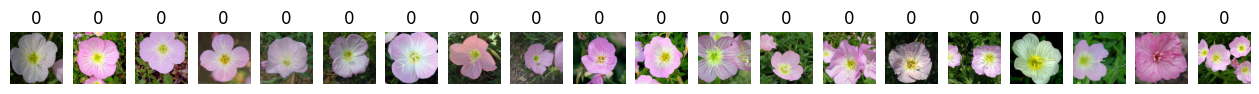

In [ ]:
_ = similarity(model_cl, dataset_test[0][0], dataset_train, k=20, specific_images=range(0, len(dataset_train)))

### Triplet loss

Epoch 0/74
----------


train Loss: 0.0898


val Loss: 0.0911

Epoch 1/74
----------


train Loss: 0.0876


val Loss: 0.0844

Epoch 2/74
----------


train Loss: 0.0851


val Loss: 0.0796

Epoch 3/74
----------


train Loss: 0.0805


val Loss: 0.0757

Epoch 4/74
----------


train Loss: 0.0802


val Loss: 0.0723

Epoch 5/74
----------


train Loss: 0.0768


val Loss: 0.0770

Epoch 6/74
----------


train Loss: 0.0754


val Loss: 0.0714

Epoch 7/74
----------


train Loss: 0.0731


val Loss: 0.0714

Epoch 8/74
----------


train Loss: 0.0727


val Loss: 0.0686

Epoch 9/74
----------


train Loss: 0.0699


val Loss: 0.0722

Epoch 10/74
----------


train Loss: 0.0692


val Loss: 0.0703

Epoch 11/74
----------


train Loss: 0.0660


val Loss: 0.0648

Epoch 12/74
----------


train Loss: 0.0655


val Loss: 0.0625

Epoch 13/74
----------


train Loss: 0.0642


val Loss: 0.0637

Epoch 14/74
----------


train Loss: 0.0631


val Loss: 0.0616

Epoch 15/74
----------


train Loss: 0.0613


val Loss: 0.0600

Epoch 16/74
----------


train Loss: 0.0594


val Loss: 0.0633

Epoch 17/74
----------


train Loss: 0.0603


val Loss: 0.0597

Epoch 18/74
----------


train Loss: 0.0592


val Loss: 0.0578

Epoch 19/74
----------


train Loss: 0.0586


val Loss: 0.0566

Epoch 20/74
----------


train Loss: 0.0576


val Loss: 0.0550

Epoch 21/74
----------


train Loss: 0.0602


val Loss: 0.0569

Epoch 22/74
----------


train Loss: 0.0559


val Loss: 0.0577

Epoch 23/74
----------


train Loss: 0.0570


val Loss: 0.0566

Epoch 24/74
----------


train Loss: 0.0572


val Loss: 0.0549

Epoch 25/74
----------


train Loss: 0.0570


val Loss: 0.0581

Epoch 26/74
----------


train Loss: 0.0572


val Loss: 0.0550

Epoch 27/74
----------


train Loss: 0.0549


val Loss: 0.0540

Epoch 28/74
----------


train Loss: 0.0559


val Loss: 0.0517

Epoch 29/74
----------


train Loss: 0.0566


val Loss: 0.0531

Epoch 30/74
----------


train Loss: 0.0544


val Loss: 0.0555

Epoch 31/74
----------


train Loss: 0.0555


val Loss: 0.0503

Epoch 32/74
----------


train Loss: 0.0553


val Loss: 0.0579

Epoch 33/74
----------


train Loss: 0.0548


val Loss: 0.0540

Epoch 34/74
----------


train Loss: 0.0572


val Loss: 0.0498

Epoch 35/74
----------


train Loss: 0.0528


val Loss: 0.0524

Epoch 36/74
----------


train Loss: 0.0547


val Loss: 0.0503

Epoch 37/74
----------


train Loss: 0.0507


val Loss: 0.0510

Epoch 38/74
----------


train Loss: 0.0517


val Loss: 0.0516

Epoch 39/74
----------


train Loss: 0.0495


val Loss: 0.0532

Epoch 40/74
----------


train Loss: 0.0489


val Loss: 0.0442

Epoch 41/74
----------


train Loss: 0.0477


val Loss: 0.0481

Epoch 42/74
----------


train Loss: 0.0453


val Loss: 0.0441

Epoch 43/74
----------


train Loss: 0.0455


val Loss: 0.0556

Epoch 44/74
----------


train Loss: 0.0469


val Loss: 0.0488

Epoch 45/74
----------


train Loss: 0.0467


val Loss: 0.0411

Epoch 46/74
----------


train Loss: 0.0422


val Loss: 0.0466

Epoch 47/74
----------


train Loss: 0.0351


val Loss: 0.0535

Epoch 48/74
----------


train Loss: 0.0351


val Loss: 0.0525

Epoch 49/74
----------


train Loss: 0.0310


val Loss: 0.0418

Epoch 50/74
----------


train Loss: 0.0288


val Loss: 0.0490

Epoch 51/74
----------


train Loss: 0.0226


val Loss: 0.0525

Epoch 52/74
----------


train Loss: 0.0219


val Loss: 0.0500

Epoch 53/74
----------


train Loss: 0.0172


val Loss: 0.0520

Epoch 54/74
----------


train Loss: 0.0194


val Loss: 0.0623

Epoch 55/74
----------


train Loss: 0.0125


val Loss: 0.0598

Epoch 56/74
----------


train Loss: 0.0103


val Loss: 0.0530

Epoch 57/74
----------


train Loss: 0.0125


val Loss: 0.0505

Epoch 58/74
----------


train Loss: 0.0126


val Loss: 0.0391

Epoch 59/74
----------


train Loss: 0.0135


val Loss: 0.0510

Epoch 60/74
----------


train Loss: 0.0077


val Loss: 0.0507

Epoch 61/74
----------


train Loss: 0.0071


val Loss: 0.0458

Epoch 62/74
----------


train Loss: 0.0070


val Loss: 0.0535

Epoch 63/74
----------


train Loss: 0.0018


val Loss: 0.0513

Epoch 64/74
----------


train Loss: 0.0061


val Loss: 0.0473

Epoch 65/74
----------


train Loss: 0.0039


val Loss: 0.0532

Epoch 66/74
----------


train Loss: 0.0036


val Loss: 0.0541

Epoch 67/74
----------


train Loss: 0.0045


val Loss: 0.0497

Epoch 68/74
----------


train Loss: 0.0080


val Loss: 0.0572

Epoch 69/74
----------


train Loss: 0.0012


val Loss: 0.0554

Epoch 70/74
----------


train Loss: 0.0064


val Loss: 0.0479

Epoch 71/74
----------


train Loss: 0.0066


val Loss: 0.0570

Epoch 72/74
----------


train Loss: 0.0000


val Loss: 0.0534

Epoch 73/74
----------


train Loss: 0.0074


val Loss: 0.0412

Epoch 74/74
----------


train Loss: 0.0020


val Loss: 0.0503

Training complete in 15m 36s
Best val loss: 0.091063


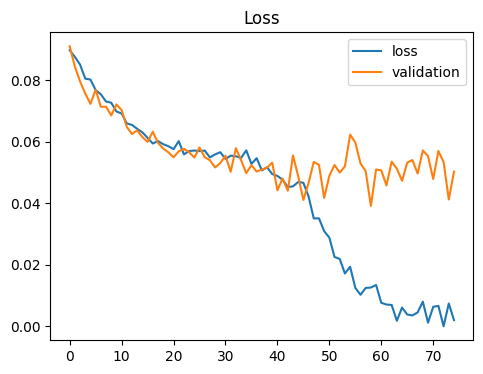

In [ ]:
# Train
model_tl = copy.deepcopy(model)
model_tl = model_tl.to(device)
optimizer_ft = optim.SGD(model_tl.parameters(), lr=0.001, momentum=0.9)
model_tl = train_model(model_tl, dataloaders_dict, optimizer_ft, num_epochs=75)

In [ ]:
similarity_performance(model_tl, dataset_train, dataset_test) 

Query shape: torch.Size([56, 512])
Query labels shape: torch.Size([56])
Reference shape: torch.Size([1071, 512])
Reference labels shape: torch.Size([1071])


{'AMI': 0.35180670244209566,
 'NMI': 0.8066679932864622,
 'mean_average_precision': 0.7322715316157429,
 'mean_average_precision_at_r': 0.6126128796726313,
 'mean_reciprocal_rank': 0.9843750596046448,
 'precision_at_1': 0.9821428571428571,
 'r_precision': 0.6717872588836828}

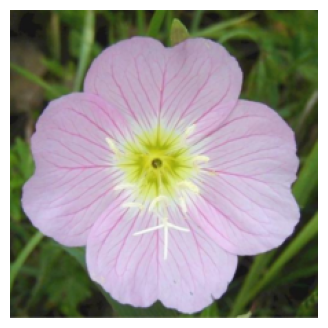

Ranking of the images: tensor([ 2, 25,  7, 12,  9, 16, 11,  6, 23,  0, 17, 14, 20,  4, 13, 10,  5,  1,
        22, 18], device='cuda:0')
Similarity: tensor([0.8885, 0.8870, 0.8714, 0.8625, 0.8408, 0.8326, 0.8267, 0.8259, 0.8247,
        0.8193, 0.8130, 0.8096, 0.8073, 0.8057, 0.8036, 0.8024, 0.7970, 0.7817,
        0.7787, 0.7730], device='cuda:0')


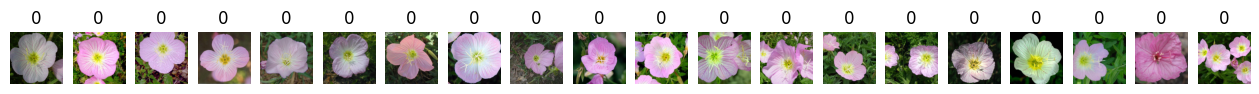

In [ ]:
_ = similarity(model_tl, dataset_test[0][0], dataset_train, k=20, specific_images=range(0, len(dataset_train)))

# Aditional executions

## Adam

### Contrastive Loss

- earliest convergence
- bad results

Epoch 0/49
----------


train Loss: 0.4433


val Loss: 0.5252

Epoch 1/49
----------


train Loss: 0.2381


val Loss: 0.2842

Epoch 2/49
----------


train Loss: 0.1730


val Loss: 0.1944

Epoch 3/49
----------


train Loss: 0.1272


val Loss: 0.3621

Epoch 4/49
----------


train Loss: 0.1135


val Loss: 0.1924

Epoch 5/49
----------


train Loss: 0.1019


val Loss: 0.1751

Epoch 6/49
----------


train Loss: 0.1248


val Loss: 0.3055

Epoch 7/49
----------


train Loss: 0.1828


val Loss: 0.4290

Epoch 8/49
----------


train Loss: 0.1847


val Loss: 0.2108

Epoch 9/49
----------


train Loss: 0.1432


val Loss: 0.2196

Epoch 10/49
----------


train Loss: 0.1389


val Loss: 0.2950

Epoch 11/49
----------


train Loss: 0.1172


val Loss: 0.1810

Epoch 12/49
----------


train Loss: 0.0968


val Loss: 0.1380

Epoch 13/49
----------


train Loss: 0.0808


val Loss: 0.1870

Epoch 14/49
----------


train Loss: 0.0818


val Loss: 0.1439

Epoch 15/49
----------


train Loss: 0.0902


val Loss: 0.2300

Epoch 16/49
----------


train Loss: 0.0976


val Loss: 0.1015

Epoch 17/49
----------


train Loss: 0.0710


val Loss: 0.1500

Epoch 18/49
----------


train Loss: 0.0952


val Loss: 0.1798

Epoch 19/49
----------


train Loss: 0.0994


val Loss: 0.1015

Epoch 20/49
----------


train Loss: 0.1038


val Loss: 0.2557

Epoch 21/49
----------


train Loss: 0.1043


val Loss: 0.1952

Epoch 22/49
----------


train Loss: 0.1241


val Loss: 0.3380

Epoch 23/49
----------


train Loss: 0.0950


val Loss: 0.1878

Epoch 24/49
----------


train Loss: 0.0869


val Loss: 0.2343

Epoch 25/49
----------


train Loss: 0.0747


val Loss: 0.1295

Epoch 26/49
----------


train Loss: 0.0594


val Loss: 0.0799

Epoch 27/49
----------


train Loss: 0.0653


val Loss: 0.0932

Epoch 28/49
----------


train Loss: 0.0569


val Loss: 0.0823

Epoch 29/49
----------


train Loss: 0.0640


val Loss: 0.0873

Epoch 30/49
----------


train Loss: 0.0623


val Loss: 0.0979

Epoch 31/49
----------


train Loss: 0.0579


val Loss: 0.0785

Epoch 32/49
----------


train Loss: 0.0538


val Loss: 0.0871

Epoch 33/49
----------


train Loss: 0.0592


val Loss: 0.0902

Epoch 34/49
----------


train Loss: 0.0577


val Loss: 0.0926

Epoch 35/49
----------


train Loss: 0.0826


val Loss: 0.2255

Epoch 36/49
----------


train Loss: 0.1043


val Loss: 0.1906

Epoch 37/49
----------


train Loss: 0.0872


val Loss: 0.1741

Epoch 38/49
----------


train Loss: 0.0711


val Loss: 0.0896

Epoch 39/49
----------


train Loss: 0.0554


val Loss: 0.0866

Epoch 40/49
----------


train Loss: 0.0592


val Loss: 0.1131

Epoch 41/49
----------


train Loss: 0.0525


val Loss: 0.1031

Epoch 42/49
----------


train Loss: 0.0523


val Loss: 0.0779

Epoch 43/49
----------


train Loss: 0.0612


val Loss: 0.0656

Epoch 44/49
----------


train Loss: 0.0653


val Loss: 0.1822

Epoch 45/49
----------


train Loss: 0.0867


val Loss: 0.2992

Epoch 46/49
----------


train Loss: 0.0650


val Loss: 0.0894

Epoch 47/49
----------


train Loss: 0.0676


val Loss: 0.0697

Epoch 48/49
----------


train Loss: 0.0627


val Loss: 0.0810

Epoch 49/49
----------


train Loss: 0.0576


val Loss: 0.0881

Training complete in 10m 22s
Best val loss: 0.525235


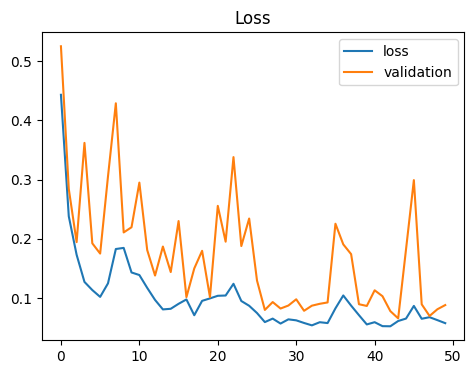

In [ ]:
model_cl_2 = copy.deepcopy(model)
model_cl_2 = model_cl_2.to(device)
optimizer_ft = optim.Adam(model_cl_2.parameters(), lr=0.001)
model_cl_2 = train_model(model_cl_2, dataloaders_dict, optimizer_ft, num_epochs=50, contrastive_loss=True)

In [ ]:
similarity_performance(model_cl_2, dataset_train, dataset_test) 

Query shape: torch.Size([56, 512])
Query labels shape: torch.Size([56])
Reference shape: torch.Size([1071, 512])
Reference labels shape: torch.Size([1071])


{'AMI': 0.5064683575659916,
 'NMI': 0.8577528652003282,
 'mean_average_precision': 0.6324583160408274,
 'mean_average_precision_at_r': 0.5169153031705289,
 'mean_reciprocal_rank': 0.8908069133758545,
 'precision_at_1': 0.8392857142857142,
 'r_precision': 0.5881381547025676}

### Triplet Loss

Epoch 0/39
----------


train Loss: 0.0813


val Loss: 0.0835

Epoch 1/39
----------


train Loss: 0.0834


val Loss: 0.0901

Epoch 2/39
----------


train Loss: 0.0796


val Loss: 0.0867

Epoch 3/39
----------


train Loss: 0.0786


val Loss: 0.0743

Epoch 4/39
----------


train Loss: 0.0796


val Loss: 0.0860

Epoch 5/39
----------


train Loss: 0.0795


val Loss: 0.0817

Epoch 6/39
----------


train Loss: 0.0745


val Loss: 0.0806

Epoch 7/39
----------


train Loss: 0.0758


val Loss: 0.0807

Epoch 8/39
----------


train Loss: 0.0714


val Loss: 0.0823

Epoch 9/39
----------


train Loss: 0.0772


val Loss: 0.0892

Epoch 10/39
----------


train Loss: 0.0745


val Loss: 0.0764

Epoch 11/39
----------


train Loss: 0.0699


val Loss: 0.0885

Epoch 12/39
----------


train Loss: 0.0725


val Loss: 0.0844

Epoch 13/39
----------


train Loss: 0.0816


val Loss: 0.0774

Epoch 14/39
----------


train Loss: 0.0727


val Loss: 0.0904

Epoch 15/39
----------


train Loss: 0.0669


val Loss: 0.0766

Epoch 16/39
----------


train Loss: 0.0713


val Loss: 0.0816

Epoch 17/39
----------


train Loss: 0.0646


val Loss: 0.0823

Epoch 18/39
----------


train Loss: 0.0651


val Loss: 0.0778

Epoch 19/39
----------


train Loss: 0.0720


val Loss: 0.0781

Epoch 20/39
----------


train Loss: 0.0784


val Loss: 0.0848

Epoch 21/39
----------


train Loss: 0.0726


val Loss: 0.0836

Epoch 22/39
----------


train Loss: 0.0654


val Loss: 0.0905

Epoch 23/39
----------


train Loss: 0.0548


val Loss: 0.0711

Epoch 24/39
----------


train Loss: 0.0633


val Loss: 0.0793

Epoch 25/39
----------


train Loss: 0.0699


val Loss: 0.0777

Epoch 26/39
----------


train Loss: 0.0702


val Loss: 0.0761

Epoch 27/39
----------


train Loss: 0.0655


val Loss: 0.0726

Epoch 28/39
----------


train Loss: 0.0621


val Loss: 0.0697

Epoch 29/39
----------


train Loss: 0.0509


val Loss: 0.0830

Epoch 30/39
----------


train Loss: 0.0748


val Loss: 0.0814

Epoch 31/39
----------


train Loss: 0.0615


val Loss: 0.0776

Epoch 32/39
----------


train Loss: 0.0669


val Loss: 0.0872

Epoch 33/39
----------


train Loss: 0.0639


val Loss: 0.0904

Epoch 34/39
----------


train Loss: 0.0628


val Loss: 0.0725

Epoch 35/39
----------


train Loss: 0.0576


val Loss: 0.0772

Epoch 36/39
----------


train Loss: 0.0650


val Loss: 0.0708

Epoch 37/39
----------


train Loss: 0.0468


val Loss: 0.0696

Epoch 38/39
----------


train Loss: 0.0588


val Loss: 0.0815

Epoch 39/39
----------


train Loss: 0.0455


val Loss: 0.0852

Training complete in 8m 20s
Best val loss: 0.090506


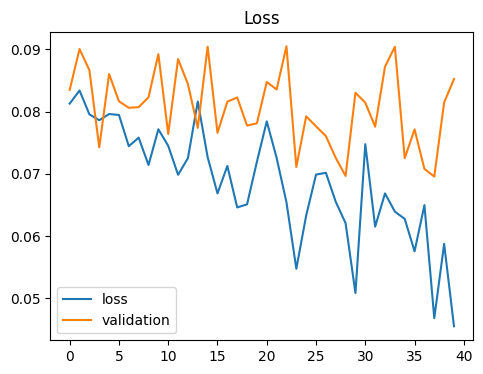

In [ ]:
model_tl_2 = copy.deepcopy(model)
model_tl_2 = model_tl_2.to(device)
optimizer_ft = optim.Adam(model_tl_2.parameters(), lr=0.001)
model_tl_2 = train_model(model_tl_2, dataloaders_dict, optimizer_ft, num_epochs=40)

In [ ]:
similarity_performance(model_tl_2, dataset_train, dataset_test) 

Query shape: torch.Size([56, 512])
Query labels shape: torch.Size([56])
Reference shape: torch.Size([1071, 512])
Reference labels shape: torch.Size([1071])


{'AMI': 0.6724208022194876,
 'NMI': 0.905043505330294,
 'mean_average_precision': 0.9505236202620457,
 'mean_average_precision_at_r': 0.9190159571834006,
 'mean_reciprocal_rank': 0.9827009439468384,
 'precision_at_1': 0.9821428571428571,
 'r_precision': 0.9288458062420772}

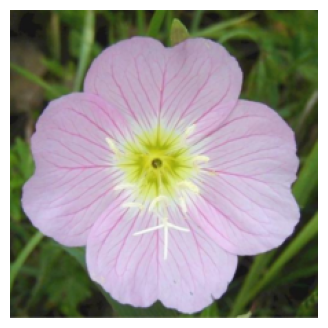

Ranking of the images: tensor([25, 12, 17,  2,  1, 13, 16,  9,  7, 11,  6, 10,  5, 20,  8,  4, 14, 26,
         0, 18], device='cuda:0')
Similarity: tensor([0.9992, 0.9978, 0.9976, 0.9961, 0.9956, 0.9956, 0.9952, 0.9905, 0.9904,
        0.9902, 0.9891, 0.9873, 0.9840, 0.9835, 0.9815, 0.9800, 0.9795, 0.9791,
        0.9777, 0.9724], device='cuda:0')


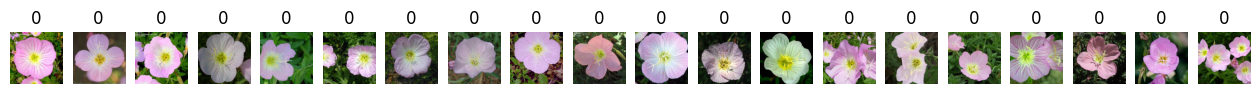

In [ ]:
_ = similarity(model_tl_2, dataset_test[0][0], dataset_train, k=20, specific_images=range(0, len(dataset_train)))

## Data augmentation

In [25]:
# New transforms with data augmentation
transform_data_augmentation = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Load again data
dataset_train = datasets.ImageFolder(root=f'{DS_PATH}/train', transform=transform)
dataset_valid = datasets.ImageFolder(root=f'{DS_PATH}/valid', transform=transform)
dataset_test = datasets.ImageFolder(root=f'{DS_PATH}/test', transform=transform)

# Create dataloaders
batch_size = 64
dataloaders_dict = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=2)
}

### Triplet Loss

Epoch 0/74
----------


train Loss: 0.0815


val Loss: 0.0791

Epoch 1/74
----------


train Loss: 0.0825


val Loss: 0.0848

Epoch 2/74
----------


train Loss: 0.0839


val Loss: 0.0781

Epoch 3/74
----------


train Loss: 0.0761


val Loss: 0.0796

Epoch 4/74
----------


train Loss: 0.0749


val Loss: 0.0974

Epoch 5/74
----------


train Loss: 0.0761


val Loss: 0.0795

Epoch 6/74
----------


train Loss: 0.0714


val Loss: 0.0878

Epoch 7/74
----------


train Loss: 0.0763


val Loss: 0.0849

Epoch 8/74
----------


train Loss: 0.0693


val Loss: 0.0743

Epoch 9/74
----------


train Loss: 0.0757


val Loss: 0.0771

Epoch 10/74
----------


train Loss: 0.0720


val Loss: 0.0842

Epoch 11/74
----------


train Loss: 0.0700


val Loss: 0.0753

Epoch 12/74
----------


train Loss: 0.0640


val Loss: 0.0944

Epoch 13/74
----------


train Loss: 0.0708


val Loss: 0.0920

Epoch 14/74
----------


train Loss: 0.0684


val Loss: 0.0776

Epoch 15/74
----------


train Loss: 0.0662


val Loss: 0.0807

Epoch 16/74
----------


train Loss: 0.0610


val Loss: 0.0813

Epoch 17/74
----------


train Loss: 0.0643


val Loss: 0.0790

Epoch 18/74
----------


train Loss: 0.0760


val Loss: 0.0803

Epoch 19/74
----------


train Loss: 0.0725


val Loss: 0.0738

Epoch 20/74
----------


train Loss: 0.0653


val Loss: 0.0775

Epoch 21/74
----------


train Loss: 0.0665


val Loss: 0.0862

Epoch 22/74
----------


train Loss: 0.0684


val Loss: 0.0887

Epoch 23/74
----------


train Loss: 0.0705


val Loss: 0.0965

Epoch 24/74
----------


train Loss: 0.0656


val Loss: 0.0717

Epoch 25/74
----------


train Loss: 0.0591


val Loss: 0.0717

Epoch 26/74
----------


train Loss: 0.0574


val Loss: 0.0793

Epoch 27/74
----------


train Loss: 0.0484


val Loss: 0.0792

Epoch 28/74
----------


train Loss: 0.0703


val Loss: 0.0708

Epoch 29/74
----------


train Loss: 0.0611


val Loss: 0.0825

Epoch 30/74
----------


train Loss: 0.0720


val Loss: 0.0745

Epoch 31/74
----------


train Loss: 0.0632


val Loss: 0.0680

Epoch 32/74
----------


train Loss: 0.0623


val Loss: 0.0752

Epoch 33/74
----------


train Loss: 0.0488


val Loss: 0.1002

Epoch 34/74
----------


train Loss: 0.0570


val Loss: 0.0875

Epoch 35/74
----------


train Loss: 0.0458


val Loss: 0.0791

Epoch 36/74
----------


train Loss: 0.0576


val Loss: 0.0753

Epoch 37/74
----------


train Loss: 0.0517


val Loss: 0.0706

Epoch 38/74
----------


train Loss: 0.0381


val Loss: 0.0771

Epoch 39/74
----------


train Loss: 0.0583


val Loss: 0.0748

Epoch 40/74
----------


train Loss: 0.0669


val Loss: 0.0626

Epoch 41/74
----------


train Loss: 0.0709


val Loss: 0.0683

Epoch 42/74
----------


train Loss: 0.0531


val Loss: 0.0756

Epoch 43/74
----------


train Loss: 0.0616


val Loss: 0.0841

Epoch 44/74
----------


train Loss: 0.0511


val Loss: 0.0804

Epoch 45/74
----------


train Loss: 0.0470


val Loss: 0.0844

Epoch 46/74
----------


train Loss: 0.0390


val Loss: 0.0797

Epoch 47/74
----------


train Loss: 0.0559


val Loss: 0.0795

Epoch 48/74
----------


train Loss: 0.0550


val Loss: 0.0701

Epoch 49/74
----------


train Loss: 0.0615


val Loss: 0.0850

Epoch 50/74
----------


train Loss: 0.0394


val Loss: 0.0758

Epoch 51/74
----------


train Loss: 0.0327


val Loss: 0.0706

Epoch 52/74
----------


train Loss: 0.0388


val Loss: 0.0674

Epoch 53/74
----------


train Loss: 0.0262


val Loss: 0.0938

Epoch 54/74
----------


train Loss: 0.0574


val Loss: 0.0769

Epoch 55/74
----------


train Loss: 0.0503


val Loss: 0.0842

Epoch 56/74
----------


train Loss: 0.0550


val Loss: 0.0790

Epoch 57/74
----------


train Loss: 0.0396


val Loss: 0.0834

Epoch 58/74
----------


train Loss: 0.0330


val Loss: 0.0868

Epoch 59/74
----------


train Loss: 0.0287


val Loss: 0.0716

Epoch 60/74
----------


train Loss: 0.0343


val Loss: 0.0817

Epoch 61/74
----------


train Loss: 0.0280


val Loss: 0.0886

Epoch 62/74
----------


train Loss: 0.0452


val Loss: 0.0800

Epoch 63/74
----------


train Loss: 0.0563


val Loss: 0.0897

Epoch 64/74
----------


train Loss: 0.0364


val Loss: 0.0646

Epoch 65/74
----------


train Loss: 0.0283


val Loss: 0.0819

Epoch 66/74
----------


train Loss: 0.0443


val Loss: 0.0932

Epoch 67/74
----------


train Loss: 0.0317


val Loss: 0.0738

Epoch 68/74
----------


train Loss: 0.0428


val Loss: 0.0725

Epoch 69/74
----------


train Loss: 0.0536


val Loss: 0.0751

Epoch 70/74
----------


train Loss: 0.0312


val Loss: 0.0782

Epoch 71/74
----------


train Loss: 0.0253


val Loss: 0.0588

Epoch 72/74
----------


train Loss: 0.0272


val Loss: 0.0787

Epoch 73/74
----------


train Loss: 0.0414


val Loss: 0.0815

Epoch 74/74
----------


train Loss: 0.0439


val Loss: 0.0788

Training complete in 15m 46s
Best val loss: 0.100233


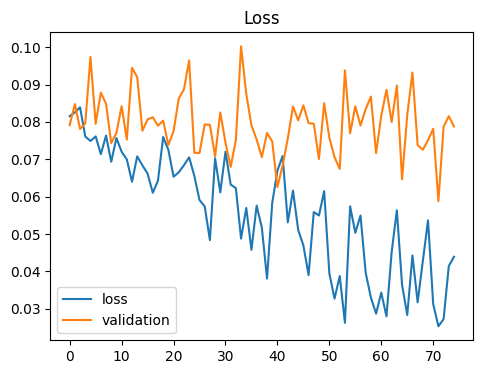

In [26]:
model_tl_da = copy.deepcopy(model)
model_tl_da = model_tl_da.to(device)
optimizer_ft = optim.Adam(model_tl_da.parameters(), lr=0.001)
model_tl_da = train_model(model_tl_da, dataloaders_dict, optimizer_ft, num_epochs=75)

In [30]:
similarity_performance(model_tl_da, dataset_train, dataset_test) 


Query shape: torch.Size([56, 512])
Query labels shape: torch.Size([56])
Reference shape: torch.Size([1071, 512])
Reference labels shape: torch.Size([1071])


{'AMI': 0.5218242578037567,
 'NMI': 0.8566836126486753,
 'mean_average_precision': 0.9050996938324843,
 'mean_average_precision_at_r': 0.8594458746448194,
 'mean_reciprocal_rank': 0.9422889947891235,
 'precision_at_1': 0.9285714285714285,
 'r_precision': 0.874154444295063}

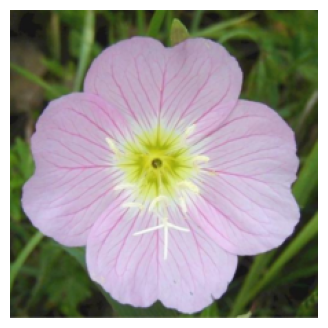

Ranking of the images: tensor([16, 11, 13, 22, 25,  7,  1, 23,  2, 17, 18, 14, 20, 12,  3,  8,  4,  6,
        19, 21], device='cuda:0')
Similarity: tensor([0.9960, 0.9946, 0.9940, 0.9934, 0.9928, 0.9923, 0.9921, 0.9904, 0.9891,
        0.9887, 0.9886, 0.9883, 0.9875, 0.9872, 0.9866, 0.9834, 0.9817, 0.9806,
        0.9797, 0.9792], device='cuda:0')


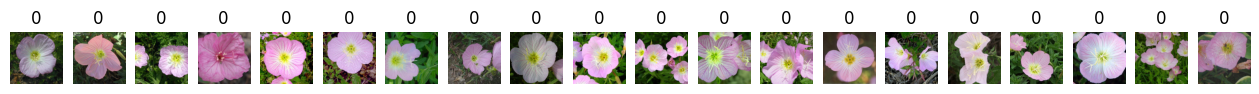

In [31]:
_ = similarity(model_tl_da, dataset_test[0][0], dataset_train, k=20, specific_images=range(0, len(dataset_train)))